# Modelo
Lo que nos interesa lograr con nuestro modelo es tener una forma de predecir de manera eficaz lo que se esta viendo en una imagen/set de imagenes astronomicos, esto es muy importante ya que los set de datos astronomicos contienen desde miles a millones de imagenes cada uno, por lo cual es necesario tener una manera eficaz de poder estudiar lo que se está observando.

Es importante destacar que nos basamos en "Alerce", mas especificamente en el proyecto "Stamp classifier".



# Caracteristicas clave
- Los datos entregados al modelo están en formato pickle, se eligió este formato debido a su simpleza y facilidad de manejo.
- Se dividió el set de datos en 2, con una proporción 80 entrenamiento/20 prueba.
- Al definir el modleo se deció hacer un data augmentation dentro de este(el cual consitió en normalizar y realizar ciertas transformaciones(como rotaciones) a imagenes al azar).
- El modelo en si es posible dividirlo en 2 grandes grupos uno convolucional y uno de metadatos, los cuales finalmente seran unidos para asi dar forma a nuestro modelo.
- Finalmente se compila y entrena el modelo
- Tras ello es posible observar distintas caracteristicas de este como gráficas de perdida y entrenamiento, junto con un output de predicción vs realiad con la diferencia entre ambas imagenes.
- Finalizado todo lo anterior se guarda el modelo

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model, Input
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
plt.style.use('dark_background')# Elección estetica

In [ ]:
# Carga de datos
AGN = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_AGN.pkl")
QSO = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_QSO.pkl")
SN = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_Super_nova.pkl")
VS = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_Variable_Star.pkl")
YSO = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_YSO.pkl")
Other = pd.read_pickle("./Dataset_chico_pickle/ztf_avro_Grande_Other.pkl")

In [ ]:
# Lista de todos los dataframes
dataframes = [AGN, QSO, VS, YSO, Other]

# Listas para almacenar los splits
X_trains = []
X_tests = []
y_trains = []
y_tests = []

# Columnas de características (todas menos 'label')
feature_columns = ['object_id', 'data', 'ra', 'dec', 'magpsf', 'sigmapsf', 'isdiffpos',
                  'diffmaglim', 'fwhm', 'sgscore1', 'sgscore2', 'sgscore3', 'distpsnr1',
                  'distpsnr2', 'distpsnr3', 'classtar', 'ndethist', 'ncovhist', 'chinr',
                  'sharpnr', 'gal_lat', 'gal_lng', 'ecl_lat', 'ecl_lng', 'approx_nondet']

# Hacer split para cada dataset
for df in dataframes:
    X = df[feature_columns]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

# Concatenar todos los datos de entrenamiento
X_train_final = pd.concat(X_trains, axis=0)
y_train_final = pd.concat(y_trains, axis=0)

# Concatenar todos los datos de prueba
X_test_final = pd.concat(X_tests, axis=0)
y_test_final = pd.concat(y_tests, axis=0)

# Mezclar aleatoriamente los datos concatenados
train_index = np.random.permutation(len(X_train_final))
test_index = np.random.permutation(len(X_test_final))

X_train_final = X_train_final.iloc[train_index].reset_index(drop=True)
y_train_final = y_train_final.iloc[train_index].reset_index(drop=True)
X_test_final = X_test_final.iloc[test_index].reset_index(drop=True)
y_test_final = y_test_final.iloc[test_index].reset_index(drop=True)

In [ ]:
# Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_final)
y_test_encoded = label_encoder.transform(y_test_final)

# Transformar a oneshot encoding
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeo de etiquetas:", label_mapping)

Mapeo de etiquetas: {'AGN': np.int64(0), 'Other': np.int64(1), 'QSO': np.int64(2), 'VS': np.int64(3), 'YSO': np.int64(4)}


- Es más estándar trabajar con el formato (N, height, width, channels)
- Las capas Conv2D de Keras están optimizadas para este formato
- Es más fácil de visualizar y debuggear

In [ ]:
metadata_columns = ['ra', 'dec', 'magpsf', 'sigmapsf', 'isdiffpos', 'diffmaglim', 'fwhm',
                  'sgscore1', 'sgscore2', 'sgscore3', 'distpsnr1', 'distpsnr2', 'distpsnr3',
                  'classtar', 'ndethist', 'ncovhist', 'chinr', 'sharpnr', 'gal_lat', 'gal_lng',
                  'ecl_lat', 'ecl_lng', 'approx_nondet']

X_train_data = np.stack(X_train_final['data'])
X_train_metadata = X_train_final[metadata_columns].values.astype('float32')

X_test_data = np.stack(X_test_final['data'])
X_test_metadata = X_test_final[metadata_columns].values.astype('float32')

# Normalizar metadatos
scaler = StandardScaler()
X_train_metadata = scaler.fit_transform(X_train_metadata)
X_test_metadata = scaler.transform(X_test_metadata)

# Transformamos de (N, 3, 21, 21) a (N, 21, 21, 3)
X_train_data = np.transpose(X_train_data, (0, 2, 3, 1))
X_test_data = np.transpose(X_test_data, (0, 2, 3, 1))

In [ ]:
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': X_train_data,
    'metadata_input': X_train_metadata
}, y_train))

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'image_input': X_test_data,
    'metadata_input': X_test_metadata
}, y_test))

train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# Set de imagenes
image_input = Input(shape=(21, 21, 3), name='image_input')

# Data Augmentation
aug = layers.Rescaling(1./255)(image_input)
aug = layers.RandomFlip("horizontal_and_vertical")(aug)
aug = layers.RandomRotation(0.2)(aug)
aug = layers.RandomZoom(0.1)(aug)
aug = layers.RandomContrast(0.1)(aug)

# Red neuronal
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(aug)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
image_output = x

# Metadatos
metadata_input = Input(shape=(23,), name='metadata_input')
y = layers.Dense(128, activation='relu')(metadata_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.25)(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.25)(y)
metadata_output = y

# Fusión
combined = layers.Concatenate()([image_output, metadata_output])
z = layers.Dense(64, activation='relu')(combined)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)
output = layers.Dense(len(label_encoder.classes_), activation='softmax')(z)

In [ ]:
model = Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 21, 21, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 21, 21, 3) │          0 │ image_input[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 21, 21, 3) │          0 │ rescaling_1[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 21, 21, 3) │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 21, 21, 3) │          0 │ random_rotation_… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 21, 21, 3) │          0 │ random_zoom_1[0]… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 21, 21,    │        896 │ random_contrast_… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 21, 21,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 10, 10,    │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 10, 10,    │     18,496 │ dropout_7[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 10, 10,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 5, 5, 64)  │          0 │ batch_normalizat

 Total params: 380,005 (1.45 MB)

 Trainable params: 378,341 (1.44 MB)

 Non-trainable params: 1,664 (6.50 KB)

#### Callbacks:
EarlyStopping:
- monitor='val_loss': Observa la pérdida en validación
- patience=10: Espera 50 épocas sin mejora antes de detener
- restore_best_weights=True: Restaura los mejores pesos encontrados

ReduceLROnPlateau:
- monitor='val_loss': También observa la pérdida en validación
- factor=0.2: Reduce la tasa de aprendizaje al 20% de su valor actual
- patience=5: Espera 10 épocas sin mejora antes de reducir la tasa
- min_lr=1e-6: No reduce la tasa por debajo de este valor

In [ ]:
# Configurar callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
]

#### Entrenamiento:

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 146s 139ms/step - accuracy: 0.4307 - loss: 1.5941 - val_accuracy: 0.4398 - val_loss: 16452231584583441155813583880192.0000 - learning_rate: 0.0010
Epoch 2/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 133s 138ms/step - accuracy: 0.5730 - loss: 1.0267 - val_accuracy: 0.5680 - val_loss: 3399273335628069303618096857088.0000 - learning_rate: 0.0010
Epoch 3/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - accuracy: 0.5913 - loss: 0.9811 - val_accuracy: 0.5771 - val_loss: 1999265607659516552529743708160.0000 - learning_rate: 0.0010
Epoch 4/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 133s 137ms/step - accuracy: 0.6109 - loss: 0.9396 - val_accuracy: 0.5005 - val_loss: 2817767624903781620635385462784.0000 - learning_rate: 0.0010
Epoch 5/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 133s 137ms/step - accuracy: 0.6166 - loss: 0.9194 - val_accuracy: 0.5686 - val_loss: 735440653187457645056398196736.0000 - learning_rate: 0.0010
Epoch 6/10
967/967 ━━━━━━━━━━━━━━━━━━━━ 133s 138ms/step - accuracy: 0.

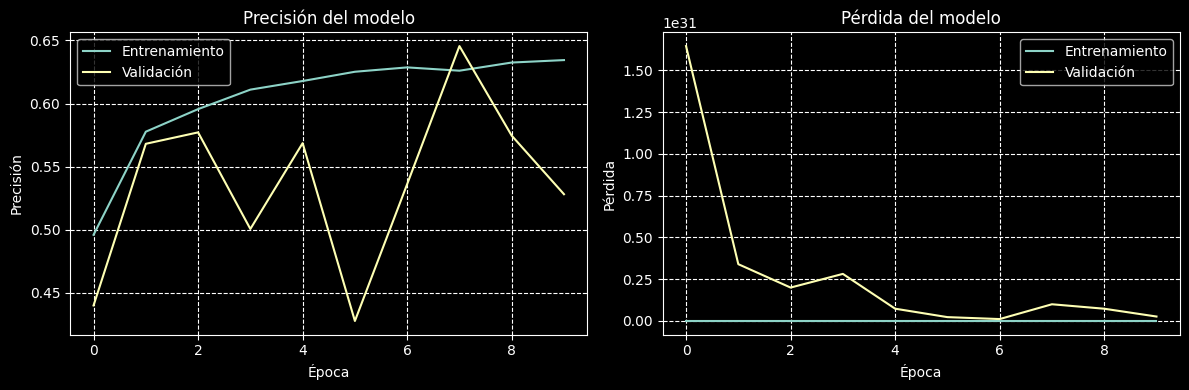

In [ ]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, linestyle = '--')
# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.grid(True, linestyle = '--')
plt.show()

Clase predicha: QSO
Clase real: QSO


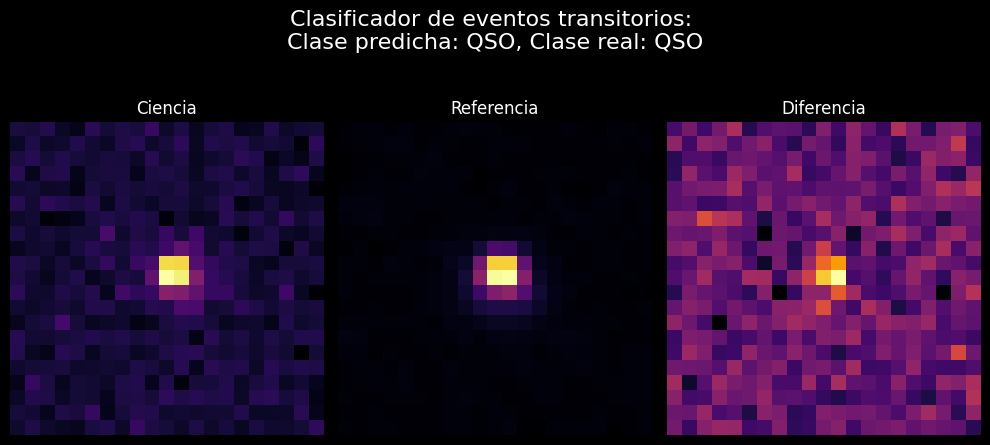

In [ ]:

numero = 124 # Elegimos una imagen al azar(se coloca a mano el nuemro de la imagen)
imagen = X_test_data[numero]
imagen = np.stack([imagen])
metadata = X_test_metadata[numero]
metadata = np.stack([metadata])

prediccion = model.predict({'image_input': imagen,'metadata_input': metadata}, verbose=0)# Predicción del modelo

clase_predicha = np.argmax(prediccion, axis=1)[0]# Clase predicha por el modelo
print(f'Clase predicha: {label_encoder.inverse_transform([clase_predicha])[0]}')

y_test_encoded[numero]
print(f'Clase real: {y_test_final.iloc[numero]}')

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle(f'Clasificador de eventos transitorios: \nClase predicha: {label_encoder.inverse_transform([clase_predicha])[0]}, Clase real: {y_test_final.iloc[numero]}', fontsize=16)
axes[0].imshow(imagen[0,:,:,0], cmap='inferno')
axes[0].set_title('Ciencia')
axes[0].axis('off')
axes[1].imshow(imagen[0,:,:,1], cmap='inferno')
axes[1].set_title('Referencia')
axes[1].axis('off')
axes[2].imshow(imagen[0,:,:,2], cmap='inferno')
axes[2].set_title('Diferencia')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Predicciones del modelo de prueba
predicciones = model.predict(test_dataset)
y_pred = np.argmax(predicciones, axis=1)
y_true = np.argmax(y_test, axis=1)

# Creación de la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Nombres de las clases
class_names = label_encoder.classes_

# Visualizamos la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.show()

 76/242 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step

In [ ]:
# Guardado del modelo
model.save('model_de_pana.keras')

In [3]:
# Cargar el modelo guardado
modelo_cargado = tf.keras.models.load_model('./modelo_entrenado_v5.keras')
# Sumario del modelo
modelo_cargado.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 21, 21, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 21, 21, 3) │          0 │ image_input[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 21, 21, 3) │          0 │ rescaling[0][0]   │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 21, 21, 3) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 21, 21, 3) │          0 │ random_rotation[… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 21, 21, 3) │          0 │ random_zoom[0][0] │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 21, 21,    │        896 │ random_contrast[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 21, 21,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 21, 21,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 10,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ batch_normalizat

 Total params: 1,136,884 (4.34 MB)

 Trainable params: 378,406 (1.44 MB)

 Non-trainable params: 1,664 (6.50 KB)

 Optimizer params: 756,814 (2.89 MB)